In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

%run optimizer.py

In [2]:
class LogisticRegression:

    def __init__(self):
        self.coeff = None

    def fit(self, X_train, Y_train, x0=np.array([-2.28, 0, 0, 0, 0, 0]), method="DFP", optimal_step=False):
        def J(x):
            return np.sum([(1 - Y_train[i]) * x @ X_train[i,:] + np.log(1 + np.exp(-x @ X_train[i,:])) for i in range(Y_train.shape[0])])

        def dJ(x):
            return np.sum(np.array([(1 - Y_train[i]) * X_train[i,:] - (X_train[i,:] / (np.exp(x @ X_train[i,:]) + 1)) for i in range(Y_train.shape[0])]),axis=0)

        self.coeff = optimize(x0, J, dJ, method, optimal_step)[-1]

    def predict(self, X_test):
        #sigmoid with calculated coefficients
        assert self.coeff is not None, "Model should be fitted first"
        return 1 / (1 + np.exp(-(self.coeff @ X_test.T)))

    def accuracy(self, target, predicted):
        predicted = np.rint(predicted)
        
        correct = 0
        for i in range(target.shape[0]):
            if target[i] == predicted[i]:
                correct += 1
        return correct / target.shape[0]
        

### Import train/test data

In [3]:
df_train = pd.read_csv('data/heart.csv',delimiter=';')
df_train['oldpeak'] = df_train['oldpeak'].str.replace(',','.')
df_train['bias'] = 1
df_train = df_train.astype(float)

y_train = df_train['target,'].to_numpy()
x_train = df_train.drop(['target,'], axis=1).to_numpy()

In [4]:
df_test = pd.read_csv('data/heart_test.csv', delimiter=";")
df_test['bias'] = 1
df_test = df_test.astype(float)

y_test = df_test['target'].to_numpy()
x_test = df_test.drop(['target'], axis=1).to_numpy()

### Fit, predict, accuracy

In [5]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predicted = lr.predict(x_test)

C:\Users\hrech\AppData\Local\Temp\ipykernel_15808\3551375174.py:8: RuntimeWarning: overflow encountered in exp
  return np.sum([(1 - Y_train[i]) * x @ X_train[i,:] + np.log(1 + np.exp(-x @ X_train[i,:])) for i in range(Y_train.shape[0])])


In [6]:
lr.accuracy(y_test, predicted)

0.7

### Confusion Matrix

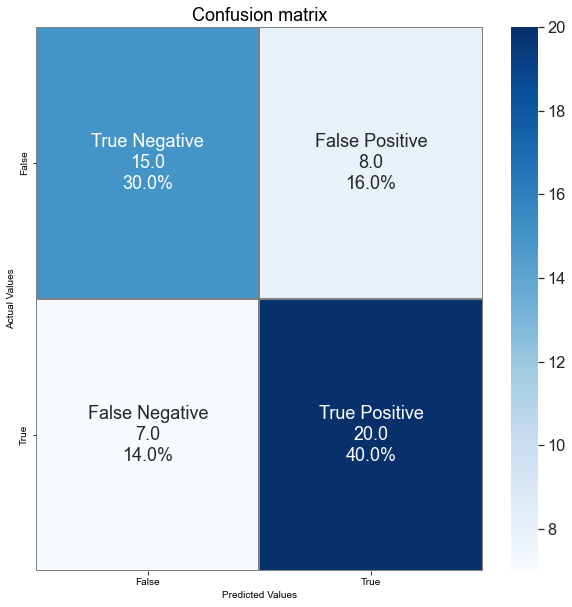

In [7]:
def confusion_matrix(test, predicted):
    rounded = np.rint(predicted)
    result = np.zeros((2, 2))

    for i in range(test.shape[0]):
        result[int(test[i])][int(rounded[i])] += 1

    labels = np.zeros((2, 2), dtype="U30")
    labels[0, 0] = f"True Negative\n{result[0, 0]}\n{100*result[0, 0]/result.sum()}%"
    labels[0, 1] = f"False Positive\n{result[0, 1]}\n{100*result[0, 1]/result.sum()}%"
    labels[1, 0] = f"False Negative\n{result[1, 0]}\n{100*result[1, 0]/result.sum()}%"
    labels[1, 1] = f"True Positive\n{result[1, 1]}\n{100*result[1, 1]/result.sum()}%"

    plt.subplots(figsize=(10, 10))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(result, annot=labels, fmt="", cmap='Blues', linecolor="gray", linewidths=0.2)
    ax.set_title("Confusion matrix")
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
confusion_matrix(y_test, predicted)